## Incremental learning with River

In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from river import metrics
import sys
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import random
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
import random
from river import anomaly
from sklearn.preprocessing import StandardScaler
from predict import binarize
import os

In [2]:
X_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_train.npy")
labels_train = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_train.npy")
X_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\X_test.npy")
labels_test = np.load("C:\\Users\\amroa\\Documents\\thesis\\labels_test.npy")

In [3]:
X_train.shape, \
X_test.shape

((544, 906), (68, 906))

In [4]:
# define hyperparameters and data
features_to_keep = 79
neighbors = 41

y_train = binarize(labels_train)
log_reg = LogisticRegression(C = 12.5) 
y_train = binarize(labels_train)
log_reg.fit(X_train, y_train)
sorted_feature_indices = np.argsort(log_reg.coef_[0])[::-1] # get the indices of the most important features in descending order

In [5]:
# dimensionality reduction (to stabilize KNN and avoid dimensionality curse)
indices = sorted_feature_indices[:features_to_keep]
X_train_top_feats = X_train[:, indices]
X_test_top_f = X_test[:, indices]
y_test = binarize(labels_test)

### Method 0: Random sampling

In [84]:
all_y_true = []
all_y_pred = []
def random_sampling_experiment(seed = 42):
    global all_y_pred, all_y_true
    nbr_train = 544
    test_accuracies = []
    for i in np.arange(24, 545, 1):
        train_indices = random.sample(range(nbr_train), i)
        data_train_rnd = X_train_top_feats[train_indices, :]
        labels_rnd = y_train[train_indices]
        log_reg = LogisticRegression(C = 0.5) 
        log_reg.fit(data_train_rnd, labels_rnd)
        y_pred = log_reg.predict(X_test_top_f)
        accuracy = accuracy_score(y_test, y_pred)
        test_accuracies.append(100*accuracy)
        if i == 50:
            all_y_true.append(y_test)
            all_y_pred.append(y_pred)
    return test_accuracies

In [85]:
test_accuracies_rnd_all_exp = []    
random.seed(12)
for i in range(30):
    test_accuracies_rnd_all_exp.append(random_sampling_experiment(seed = i))

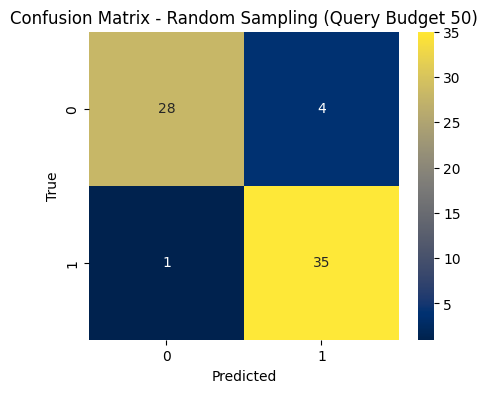

In [102]:
modes_pred = all_y_pred[0]
modes_true = all_y_true[0]
cm = confusion_matrix(modes_true, modes_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Random Sampling (Query Budget 50)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Method 1: Entropy-sampling 

In [106]:
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics
import re

def testing_model_entropy_sampling(model, X_test_top_f, save_y):
    y_test = binarize(labels_test)

    X_river_test = [
        {f"feature_{i}": value for i, value in enumerate(sample)}
        for sample in X_test_top_f
    ]
    y_river_test = y_test.tolist()  
    metric = metrics.Accuracy()

    preds_y = []
    true_y = []

    # Process each sample in the dataset
    for i in range(len(X_river_test)):
        x = X_river_test[i]
        y_true = y_river_test[i]
        y_pred, _ = model.predict_one(x) 
        metric = metric.update(y_true, y_pred)
        if save_y:
            preds_y.append(y_pred)
            true_y.append(y_true)

    return metric, preds_y, true_y

acc_train_all_exp = []
acc_test_all_exp = []
n_samples_all_exp = []

all_y_pred_en = []
all_y_true_en = []
# across 50 seeds
for s in range(50):
    accuracies_train = []
    accuracies_test = []
    samples_used = []
    for i in range(0, 1000, 5):
        save_y = False
        # Prepare the data in a format compatible with river
        X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_feats
        ]
        y_river = y_train.tolist() 

        metric = metrics.Accuracy()
        base_model = linear_model.LogisticRegression()
        model = active.EntropySampler(base_model, discount_factor=i, seed=s)

        n_samples_used = 0

        # Process each sample in the dataset
        for i in range(len(X_river)):
            x = X_river[i]
            y_true = y_river[i]
            y_pred, ask = model.predict_one(x) 
            metric = metric.update(y_true, y_pred)

            if ask:
                n_samples_used += 1
                model = model.learn_one(x, y_true)  # Learn from the true label
        
        if n_samples_used == 50:
            save_y = True
                
        if len(samples_used) > 0 and (samples_used[-1] <= n_samples_used):
            continue

        acc_train = float((re.search(r'(\d+\.\d+)', metric.__str__())).group(1))
        accuracies_train.append(acc_train)
        samples_used.append(n_samples_used)
        #print(f"Number of samples used for learning: {n_samples_used}")
        metric, preds_y, true_y = testing_model_entropy_sampling(model, X_test_top_f, save_y)
        if save_y:
            all_y_pred_en = preds_y
            all_y_true_en = true_y
        save_y = False
        acc_test = float((re.search(r'(\d+\.\d+)', metric.__str__())).group(1))
        accuracies_test.append(acc_test)

    acc_test_all_exp.append(accuracies_test[::-1])
    acc_train_all_exp.append(accuracies_train[::-1])
    n_samples_all_exp.append(samples_used[::-1])

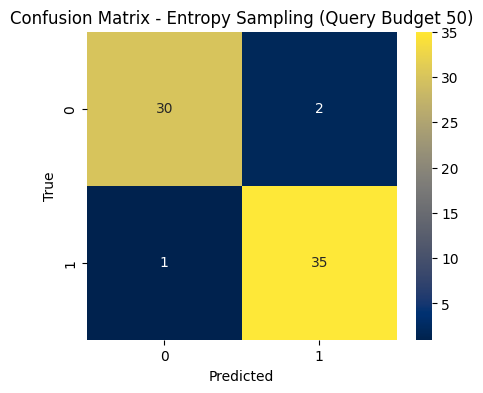

In [109]:
modes_pred = all_y_pred_en
modes_true = all_y_true_en
cm = confusion_matrix(modes_true, modes_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap = "cividis")
plt.title("Confusion Matrix - Entropy Sampling (Query Budget 50)")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [14]:
def find_common_numbers(list_of_arrays):
    common_numbers = set(list_of_arrays[0])
    for arr in list_of_arrays[1:]:
        common_numbers &= set(arr)
    return list(common_numbers)

find_common_numbers(n_samples_all_exp) # this is why need interpolation

[544]

In [15]:
def interp_with_extrapolation(x, xp, fp): # interp uses constant extrapolation, this uses slope-based
    y = np.interp(x, xp, fp)
    return y

In [26]:
interpolation_range_samples = np.arange(24, 545, 1)
interp_accs_train = []
interp_accs_test = []
for i in range(len(n_samples_all_exp)):
    exp_i_samples = n_samples_all_exp[i]
    exp_i_acc_train = acc_train_all_exp[i]
    exp_i_acc_test = acc_test_all_exp[i]
    
    interp_extrap_train_i = interp_with_extrapolation(interpolation_range_samples, exp_i_samples, exp_i_acc_train)
    interp_extrap_test_i = interp_with_extrapolation(interpolation_range_samples, exp_i_samples, exp_i_acc_test)
    
    interp_accs_test.append(interp_extrap_test_i)
    interp_accs_train.append(interp_extrap_train_i)

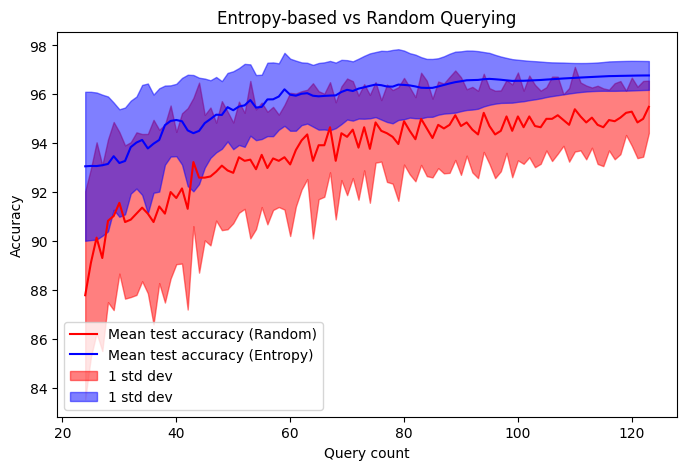

In [56]:
# the fill between plot
import matplotlib.pyplot as plt
#y_train_mean = np.mean(interp_accs_train, axis=0)
y_test_rnd_mean = np.mean(test_accuracies_rnd_all_exp, axis = 0)
y_test_mean  = np.mean(interp_accs_test, axis = 0)
#train_std = np.std(interp_accs_train, axis=0)
test_std = np.std(interp_accs_test, axis=0)
test_rnd_std = np.std(test_accuracies_rnd_all_exp, axis=0)

# increase width of plot
plt.figure(figsize=(8, 5))
end = 100
x = ((interpolation_range_samples)[0:end])
plt.plot(x, y_test_rnd_mean[0:end], '-r', label='Mean test accuracy (Random)')
plt.plot(x, y_test_mean[0:end], '-b', label='Mean test accuracy (Entropy)')

plt.fill_between(x, (y_test_rnd_mean - test_rnd_std)[0:end], (y_test_rnd_mean + test_rnd_std)[0:end], color='red', alpha=0.5, label='1 std dev')
plt.fill_between(x, (y_test_mean - test_std)[0:end], (y_test_mean + test_std)[0:end], color='blue', alpha=0.5, label='1 std dev')
plt.title("Entropy-based vs Random Querying")
plt.xlabel("Query count")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#### Plot the entropy (~anomaly score)

In [57]:
def calculate_entropy(y_pred):
    probabilities = y_pred
    entropy = -sum(p * np.log2(p) for p in probabilities.values() if p > 0)
    return entropy

In [58]:
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in X_train_top_feats
]
y_river = y_train.tolist() 

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression()
model = active.EntropySampler(base_model, discount_factor=1, seed=42)
n_samples_used = 0
entropies = []

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_proba_one(x) 
    entropy_cur = calculate_entropy(y_pred)
    entropies.append(entropy_cur)
    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

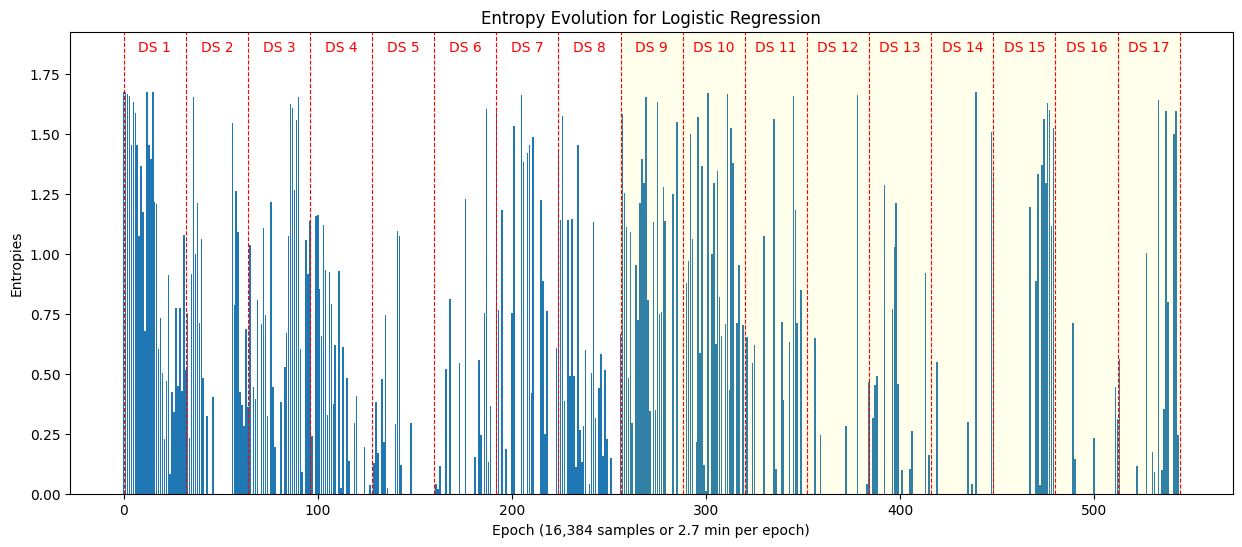

In [80]:
import matplotlib.pyplot as plt
sns.reset_defaults()
sns.reset_orig()
plt.figure(figsize=(15, 6))
nbr_epochs = 544
entropies_reshaped = np.array(entropies).reshape(-1, 1)
for i in range(0, nbr_epochs+1, 32):
    plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)
sc = StandardScaler()
obs = np.arange(len(entropies))
std_entropies = sc.fit_transform(entropies_reshaped).flatten()
plt.bar(obs, std_entropies)
plt.ylim(0, 1.15*max(std_entropies))

# color the damage states
plt.axvspan(32*8, 32*17, color='yellow', alpha=0.08)

plt.xlabel('Epoch (16,384 samples or 2.7 min per epoch)')
plt.ylabel('Entropies')
plt.title(f'Entropy Evolution for Logistic Regression')
text_pos = [i+16 for i in range(0, 544, 32)]
for idx, pos in enumerate(text_pos):
    plt.text(pos, max(std_entropies)*1.1, f'DS {idx+1}', ha='center', color='red')

plt.show()

### Method 2: Changepoint detection using Gaussian scoring

In [81]:
def gaussian_scorer_multi(y_values, window_size = 25, grace_period = 10, method = 0, plot = True):
    """
    Method: 0 if min of Gaussian anomaly scores for each variable, 1 if max of Gaussian anomaly scores, and 2 if product of scores, 3 if median of scores
    """
    from functools import reduce
    num_vals = y_values.shape[1]
    rng = random.Random(42)
    detectors = [anomaly.GaussianScorer(window_size=window_size, grace_period=grace_period) for el in range(num_vals)]
    anomaly_scores = [[0] for el in range(num_vals)]

    for idx, detector in enumerate(detectors):
        for obs_idx, y in enumerate(y_values[:-1, idx]):
            detector = detector.learn_one(None, y) 
            anomaly_scores[idx].append(detector.score_one(None, y_values[obs_idx+1, idx]))

    anomaly_scores_np = [np.array(el) for el in anomaly_scores]
    result = np.minimum.reduce(anomaly_scores_np) if method == 0 else \
         np.maximum.reduce(anomaly_scores_np) if method == 1 else reduce(np.multiply, anomaly_scores_np) if method == 2 else np.median(np.vstack(anomaly_scores_np), axis=0)
    mnmx = StandardScaler()
    obs = np.arange(len(result))
    normalized_result = mnmx.fit_transform(result.reshape(-1, 1)).flatten()
    if plot:
        import matplotlib.pyplot as plt
        sns.reset_defaults()
        sns.reset_orig()
        plt.figure(figsize=(15, 6))
        nbr_epochs = 544
        for i in range(0, nbr_epochs+1, 32):
            plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)
        plt.bar(obs, normalized_result)
        plt.ylim(0, 1.15*max(normalized_result))
        # color the damage states
        plt.axvspan(32*8, 32*17, color='yellow', alpha=0.08)
        string_method = "min_i" if method == 0 else "max_i" if method == 1 else "\prod_i" if method == 2 else "med_i"
        plt.xlabel('Observation (16,384 samples or 2.7 min per observation)')
        plt.ylabel('(Standardized) Gaussian anomaly score')
        plt.title(rf'Anomaly score: $score = 2\ {string_method} \|CDF(x_i) - 0.5\|$')
        text_pos = [i+16 for i in range(0, 544, 32)]
        for idx, pos in enumerate(text_pos):
            plt.text(pos, max(normalized_result)*1.1, f'DS {idx+1}', ha='center', color='red')

        plt.show()
    return result, normalized_result

In [8]:
def plot_distribution(data, title, window = None, threshold = None, damage_zone = None):    
    sns.set_style('whitegrid')
    plt.figure(figsize=(10, 6))
    
    if window is not None:
        data = data[np.logical_and(data >= window[0], data <= window[1])]
    
    if threshold is not None and damage_zone is None:
        below_threshold = data[data < threshold]
        above_threshold = data[data >= threshold]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold, bins='auto', color='cyan', edgecolor='black', label='Above Threshold')
        plt.legend()
    elif threshold is not None and damage_zone is not None:
        below_threshold = data[data < threshold]
        above_threshold_idx = np.where(data >= threshold)[0]
        print(above_threshold_idx)
        above_threshold_damage = [data[idx] for idx in above_threshold_idx if damage_zone(idx)]
        above_threshold_nodam = [data[idx] for idx in above_threshold_idx if not damage_zone(idx)]
        sns.histplot(below_threshold, bins='auto', color='#86bf91', edgecolor='black', label='Below Threshold')
        sns.histplot(above_threshold_nodam, bins='auto', color='cyan', edgecolor='black', label='Above Threshold (Undamaged)')
        sns.histplot(above_threshold_damage, bins='auto', alpha = 0.6, color='red', edgecolor='black', label='Above Threshold (Damaged)')
        print(f"{len(below_threshold)} are below threshold, {len(above_threshold_damage)} are above threshold with damaged, and {len(above_threshold_nodam)} are above threshold undamaged")
        plt.legend()
    else:
        sns.histplot(data, bins='auto', color='#86bf91', edgecolor='black')
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Standardized anomaly score', fontsize=14, labelpad=15)
    plt.ylabel('Frequency', fontsize=14, labelpad=15)
    plt.tight_layout()
    plt.show()
    
    sns.reset_defaults()
    sns.reset_orig()

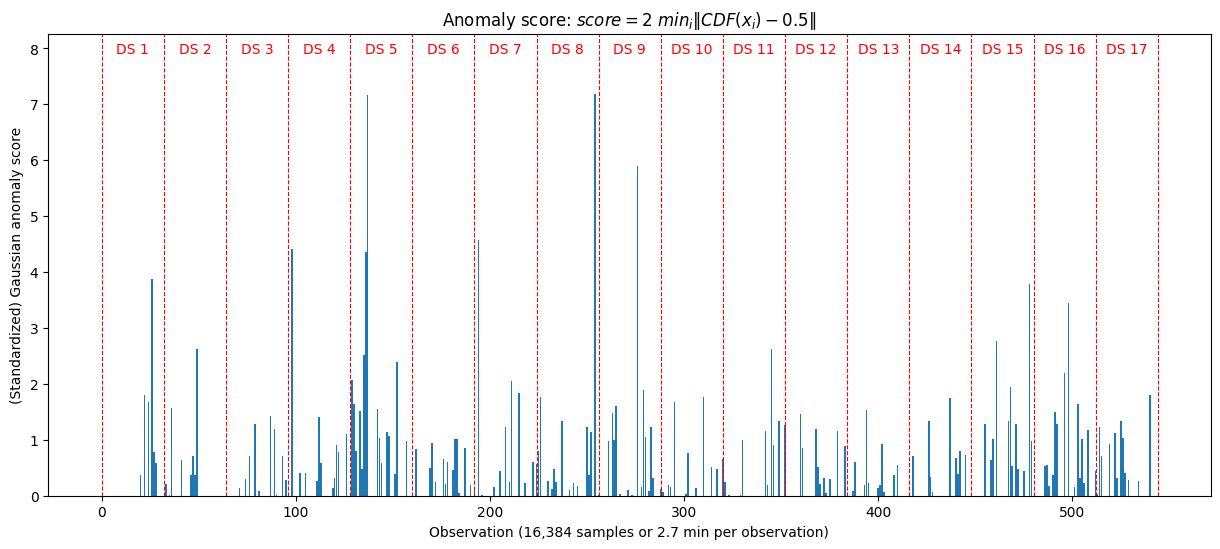

array([137, 254], dtype=int64)

In [9]:
result, n_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20)
np.where(n_res > 6)[0]

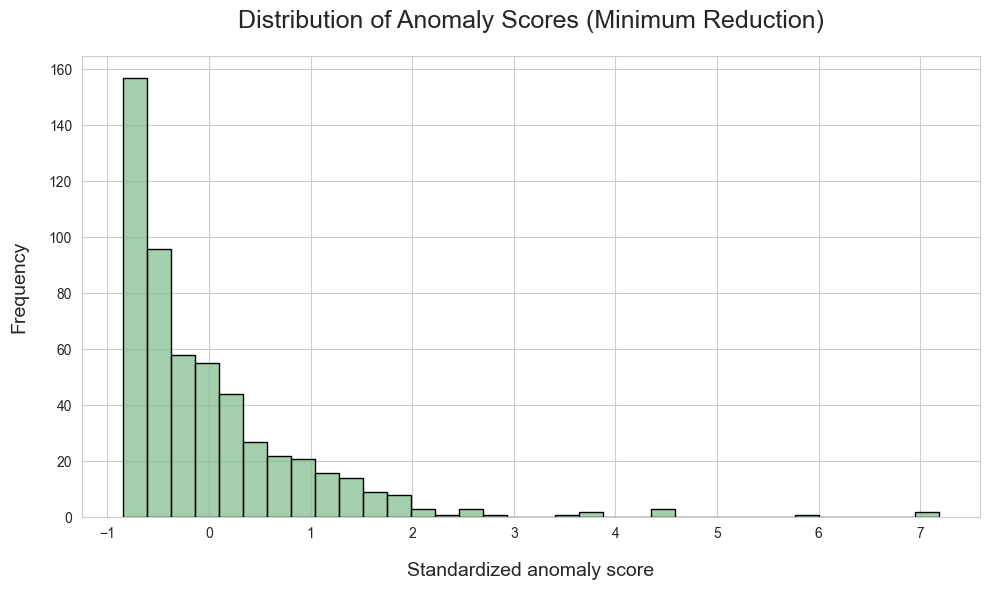

In [11]:
plot_distribution(n_res, 'Distribution of Anomaly Scores (Minimum Reduction)')

In [632]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 254)

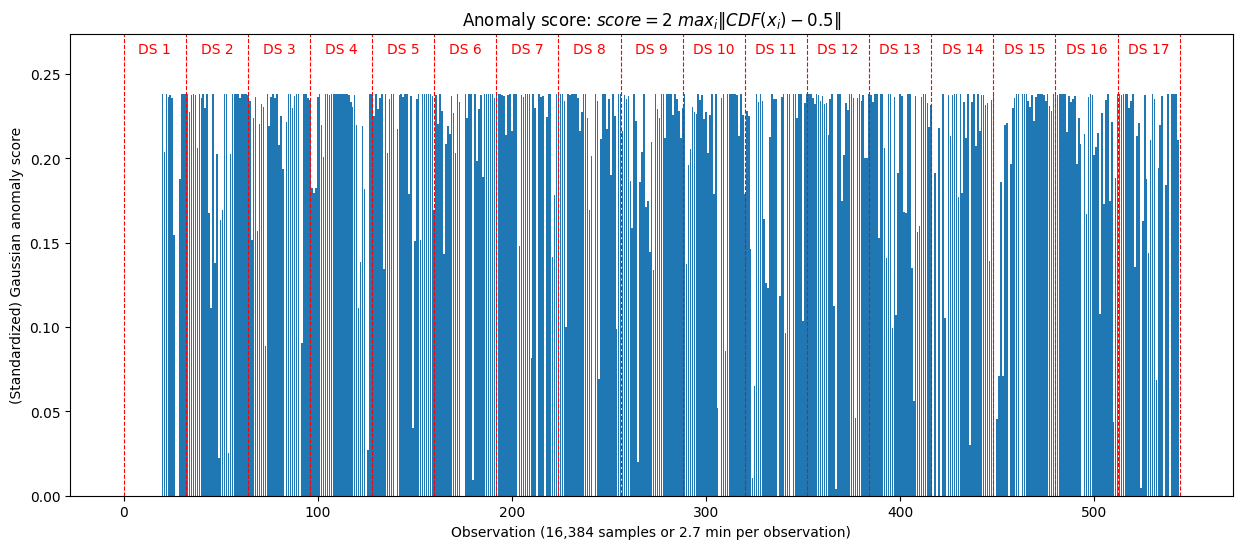

In [665]:
result, n_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20, method = 1) # max this time. REMARK: graph is very noisy. Taking a max is not a great idea

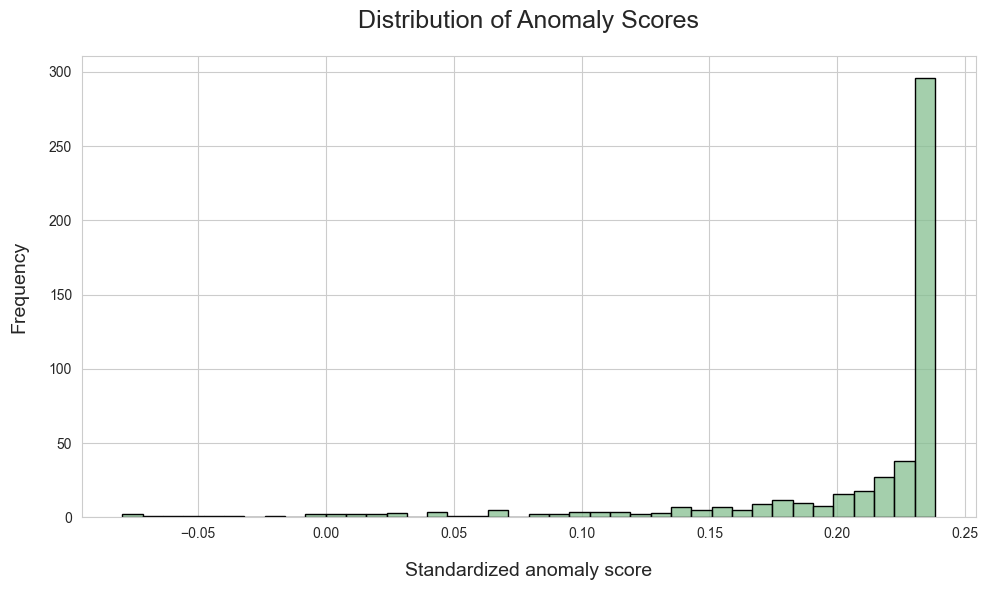

In [666]:
plot_distribution(n_res, 'Distribution of Anomaly Scores', window  = [-0.1, 1])

In [542]:
np.where(y_train == 1)[0][0:20], \
np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 36)

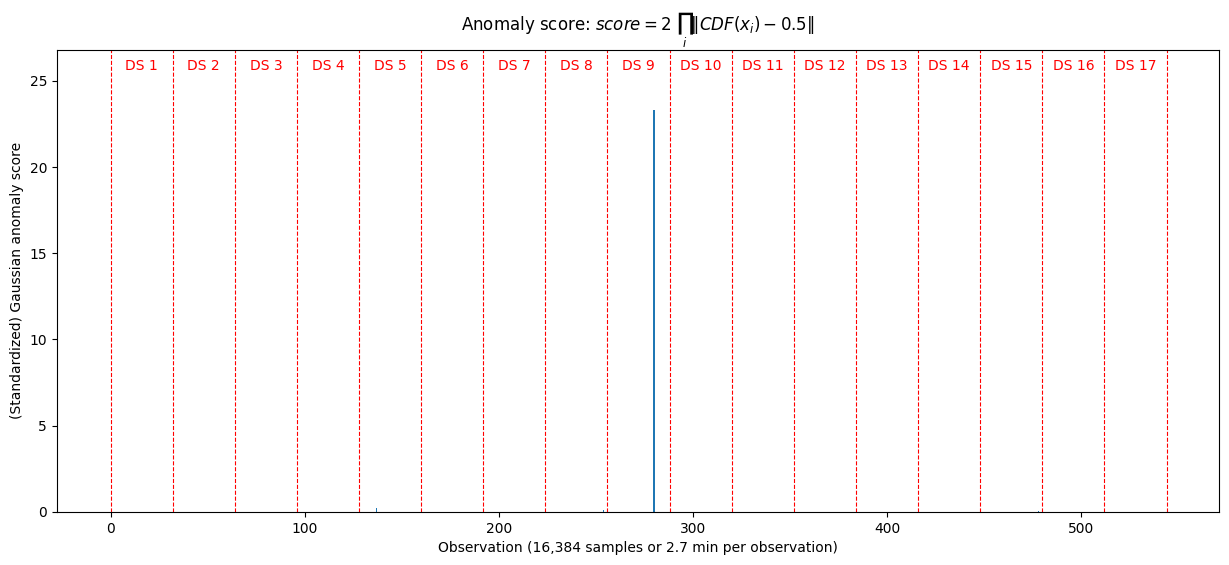

In [28]:
result, n_res = gaussian_scorer_multi(X_train_top_feats, window_size =45, grace_period = 20, method = 2) # product this time

In [29]:
#plot_distribution(n_res, 'Distribution of Anomaly Scores')

In [660]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 2.1481348189988868e-16,
 280)

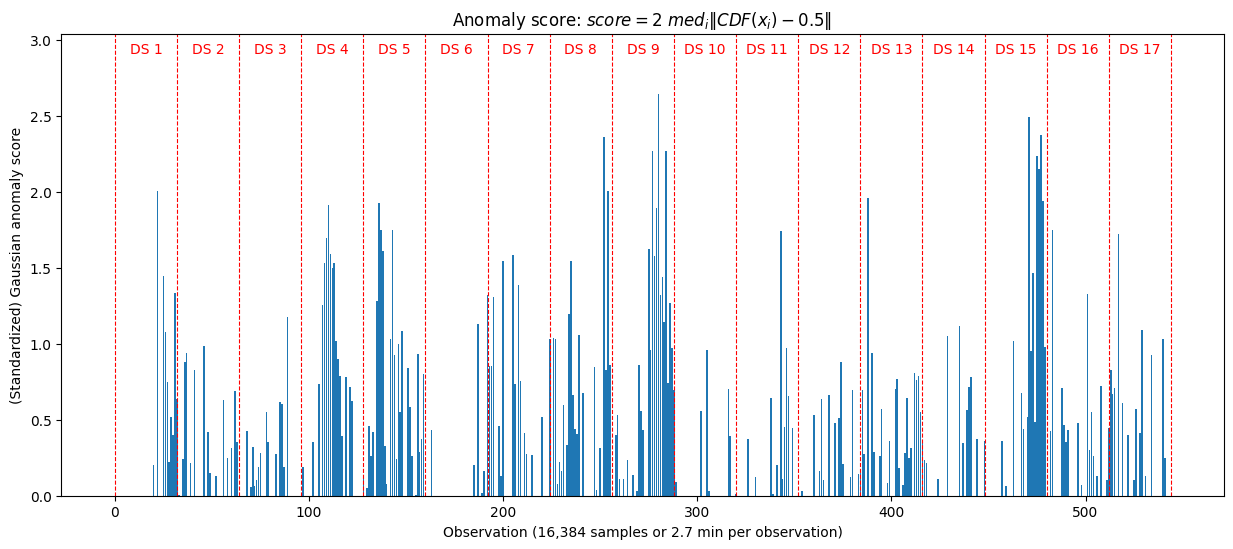

In [33]:
result, n_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45, grace_period = 20, method = 3) # median this time

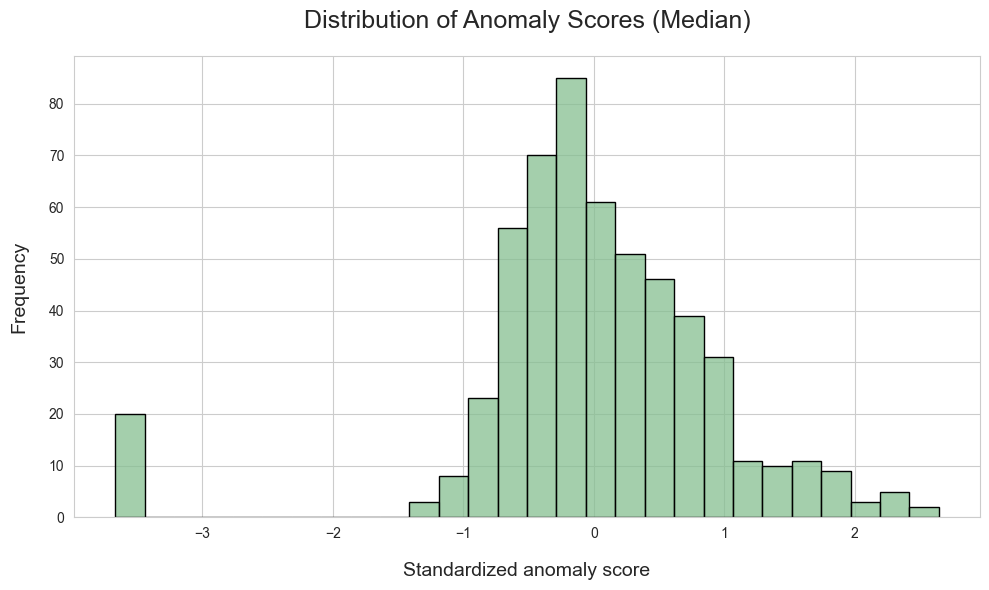

In [34]:
plot_distribution(n_res, 'Distribution of Anomaly Scores (Median)')

In [550]:
np.where(y_train == 1)[0][0:20], \
np.max(result), np.argmax(result)

(array([256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
        269, 270, 271, 272, 273, 274, 275], dtype=int64),
 0.8087748785796025,
 280)

In [52]:
# turn these methods into AL algorithms
class AL:
    def __init__(self, anomaly_scores, threshold, labels_after_chgpt, warm_start = False):
        self.threshold = threshold
        self.anomaly_scores = anomaly_scores
        self.labels_after_chgpt = labels_after_chgpt # how many samples to query after changepoint
        self.warm_start = warm_start
    def query(self):
        self.sample_points = np.where(self.anomaly_scores >= self.threshold)[0]
        return self.sample_points # these are only start points of sampling
    def get_label_points(self): # indices of samples to label
        self.query()
        querying_points = []
        # avoid sampling across boundaries 
        def boundary(num):
            bin = num // 32
            return 32*(bin+1) - 1
        [[querying_points.append(min(num+i, boundary(num))) for i in range(self.labels_after_chgpt)] for num in self.sample_points]
        # warm start, comment the next line to avoid warm start
        if self.warm_start:
            querying_points = querying_points + list(range(10))
        res = list(set(querying_points))
        res.sort()
        return res

In [84]:
def ad_to_al(normalized_res, warm_st):
    samples_used = []
    test_accuracies = []
    train_accuracies = []
    print(max(normalized_res))
    mx = max(normalized_res)
    mn = min(normalized_res)

    for i in np.linspace(mn, mx, 14):
        for j in range(1, 11):
            al_min = AL(normalized_res, threshold=i, labels_after_chgpt=j, warm_start=warm_st)
            indices_to_query = al_min.get_label_points()
            indices_to_query = [i for i in indices_to_query if i < X_train.shape[0]]
            samples_used.append(len(indices_to_query))
            train_data = X_train_top_feats[indices_to_query, :]
            train_labels = y_train[indices_to_query]

            if np.unique(train_labels).size == 1:
                print("The training data contains only one unique number") 
                test_accuracies.append(0.5) 
                train_accuracies.append(0.5)
                continue

            log_reg = LogisticRegression(C=0.5) 
            log_reg.fit(train_data, train_labels)
            y_pred = log_reg.predict(X_test_top_f)
            accuracy = accuracy_score(y_test, y_pred)
            test_accuracies.append(accuracy)

            # predict training subset and compute accuracy
            y_train_pred = log_reg.predict(train_data)
            train_accuracy = accuracy_score(train_labels, y_train_pred)
            train_accuracies.append(train_accuracy)
            #print(f"Threshold={i}, Labels After Chgpt={j}: Accuracy={accuracy}%")
    return test_accuracies, train_accuracies, samples_used

In [154]:
# AL
accuracies_train_all_exp = [] # second element for med gaussian sampling
accuracies_test_all_exp = [] # first element for min gaussian sampling
n_samples_all_exp = []
for met_iter in [0, 3, 2]:
    method = met_iter
    _, normalized_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45,  grace_period = 20, method=met_iter, plot=False) # min aggregation
    print(len(normalized_res))
    test_accuracies, train_accuracies, samples_used = ad_to_al(normalized_res, warm_st=False)
    accuracies_test_all_exp.append(test_accuracies)
    accuracies_train_all_exp.append(train_accuracies)
    n_samples_all_exp.append(samples_used)

544
7.185322053693818
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains o

In [155]:
def plot_contour_al(accuracies_train_min, accuracies_test_min, n_samples_min):
    acc_train_matrix = np.array(accuracies_train_min).reshape(14, 10)
    acc_test_matrix = np.array(accuracies_test_min).reshape(14, 10)
    samples_matrix = np.array(n_samples_min).reshape(14, 10)
    print(np.max(np.max(acc_test_matrix, axis = 0)))

    labels_after = np.arange(1, 11)
    threshold = np.arange(int(len(accuracies_test_min)/len(labels_after)))
    X, Y = np.meshgrid(labels_after, threshold)

    fig, axs = plt.subplots(2, 2, figsize=(15, 13.5))  # 2 row, 2 columns

    # Plot for samples_matrix
    cp1 = axs[0][0].contourf(X, Y, samples_matrix, cmap='viridis')
    fig.colorbar(cp1, ax=axs[0][0], label='Query count')
    axs[0][0].set_xlabel("Label run-length")
    axs[0][0].set_ylabel("Anomaly threshold")
    axs[0][0].set_title("Effect of label run-length and threshold on query count", y=1.05)

    # Plot for acc_test_matrix
    cp2 = axs[0][1].contourf(X, Y, acc_test_matrix, levels = 20, cmap='viridis')
    fig.colorbar(cp2, ax=axs[0][1], label='Test Accuracy')
    axs[0][1].set_xlabel("Label run-length")
    axs[0][1].set_ylabel("Anomaly threshold")
    axs[0][1].set_title("Effect of label run-length and threshold on accuracy", y=1.05)

    # Plot for acc_train_matrix
    cp3 = axs[1][0].contourf(X, Y, acc_train_matrix, levels = 20, cmap='viridis')
    fig.colorbar(cp3, ax=axs[1][0], label='Train accuracy')
    axs[1][0].set_xlabel("Label run-length")
    axs[1][0].set_ylabel("Anomaly threshold")
    axs[1][0].set_title("Effect of label run-length and threshold on accuracy", y=1.05)

    # If you have another plot, you can add it with axs[1][1]. Otherwise, you can turn it off:
    axs[1][1].axis('off')

    plt.tight_layout()
    plt.show()

    return acc_train_matrix, acc_test_matrix, samples_matrix

0.9558823529411765


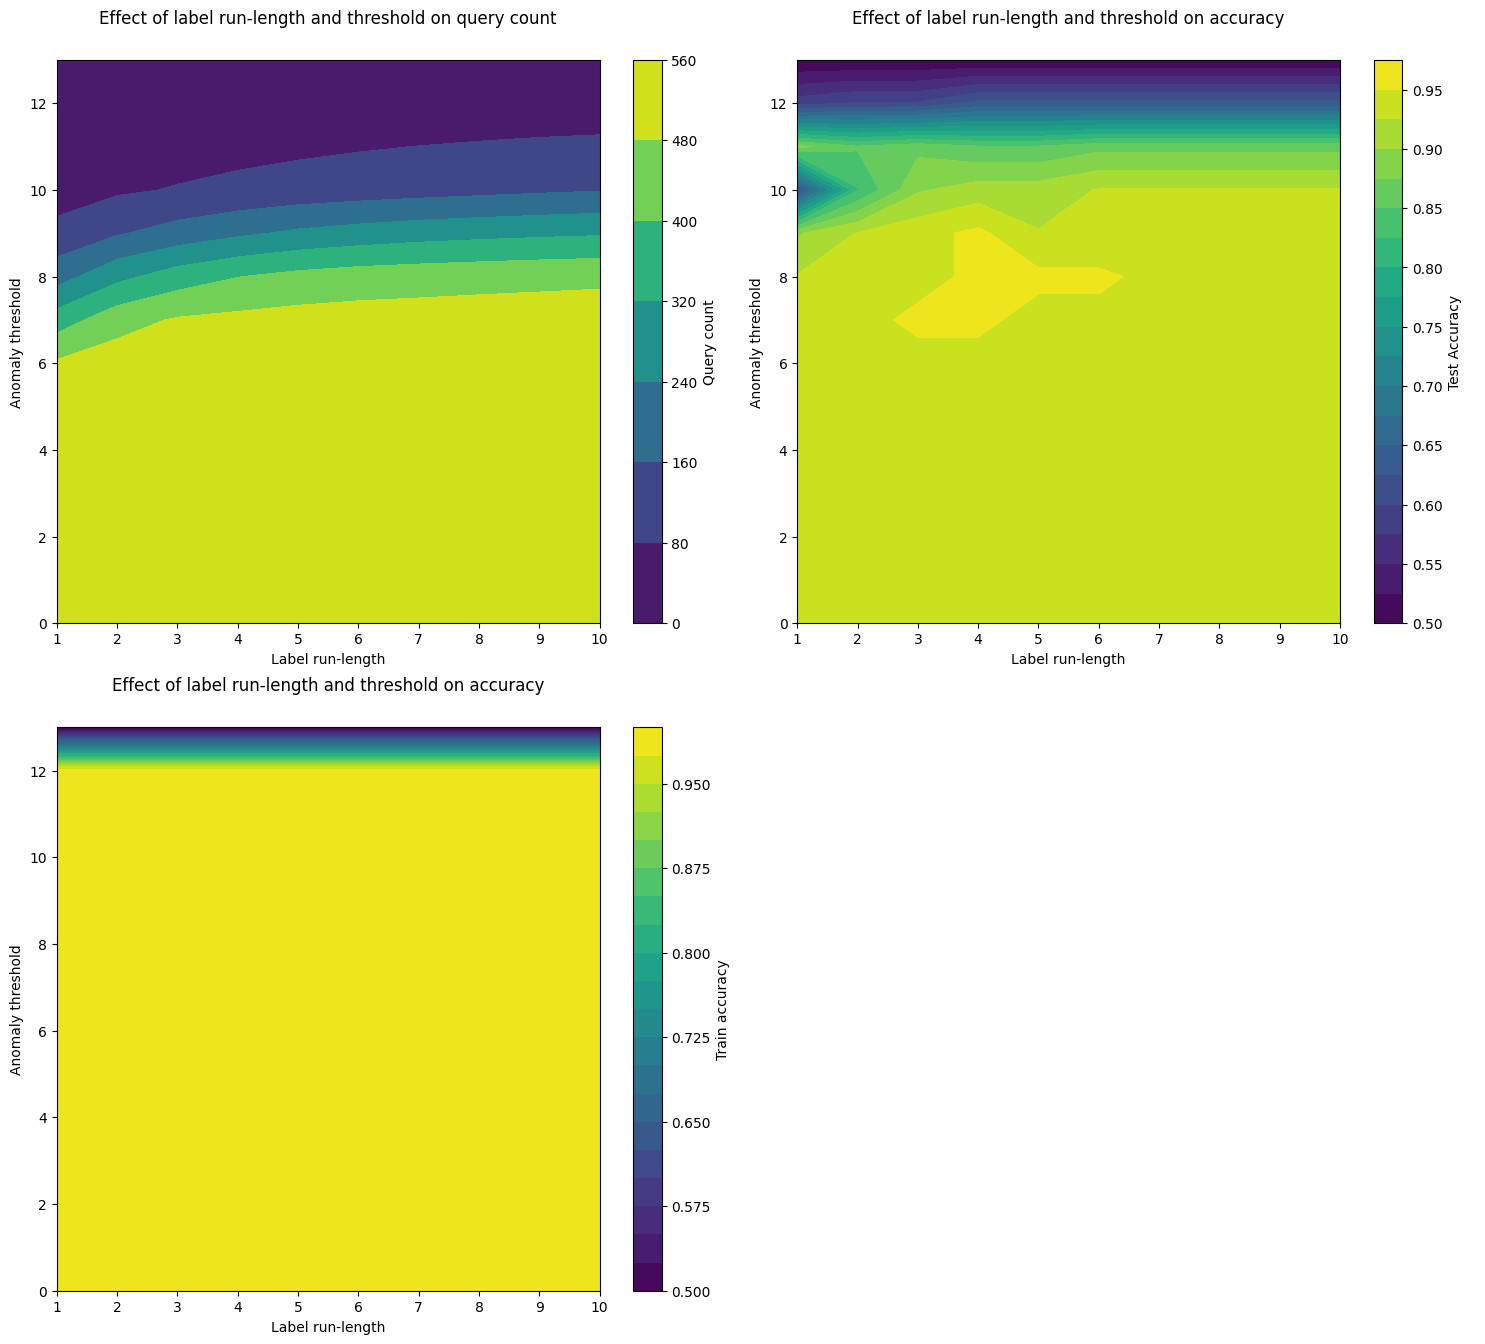

In [156]:
# we consider the min here first 
accuracies_train_min = accuracies_train_all_exp[1] # second element for med gaussian sampling
accuracies_test_min = accuracies_test_all_exp[1] # first element for min gaussian sampling
n_samples_min = n_samples_all_exp[1]

acc_train_matrix, acc_test_matrix, samples_matrix = plot_contour_al(accuracies_train_min, accuracies_test_min, n_samples_min)

In [278]:
def plot_accuracy_diff_thresholds(range_thresholds, acc_test_matrix, samples_matrix):
    test_accuracies_thresh_all = [acc_test_matrix[i, :] for i in range_thresholds]

    n_samples_all = [samples_matrix[i, :] for i in range_thresholds]

    test_accuracies_thresh_all = [test_accuracies_thresh_all[i][n_samples_all[i] < 100] for i in range(len(range_thresholds))]

    n_samples_all = [n_samples_all[i][n_samples_all[i] < 100] for i in range(len(range_thresholds))]

    # make the colors close together
    colors = plt.cm.jet(np.linspace(0.10, 0.45, len(range_thresholds)))
    plt.figure(figsize=(8, 5))

    alpha = 0.7
    # add markers 
    for i in range(len(range_thresholds)):
        plt.plot(n_samples_all[i], test_accuracies_thresh_all[i], color=colors[i], alpha = alpha, label=f'Threshold {range_thresholds[i]}', 
                linewidth=2, linestyle='-', marker='o', markersize=5)
        print(n_samples_all[i])
        print(test_accuracies_thresh_all[i])
        print("***")

    plt.title('Test Accuracies across Anomaly Thresholds')
    plt.xlabel('Query count')
    plt.ylabel('Accuracy')

    plt.grid(True, which='major', linestyle='--', linewidth=0.5)
    num_ticks = 9  # or however many you want
    x_ticks = np.linspace(10, 50, num_ticks)
    plt.xticks(x_ticks)
    plt.yticks(np.linspace(0.5, 1, 11))
    plt.legend()
    plt.tight_layout()
    plt.show()

[44 69 85 98]
[0.61764706 0.82352941 0.89705882 0.91176471]
***
[21 36 47 58 66 74 81 88 95]
[0.88235294 0.85294118 0.86764706 0.85294118 0.85294118 0.86764706
 0.86764706 0.86764706 0.86764706]
***


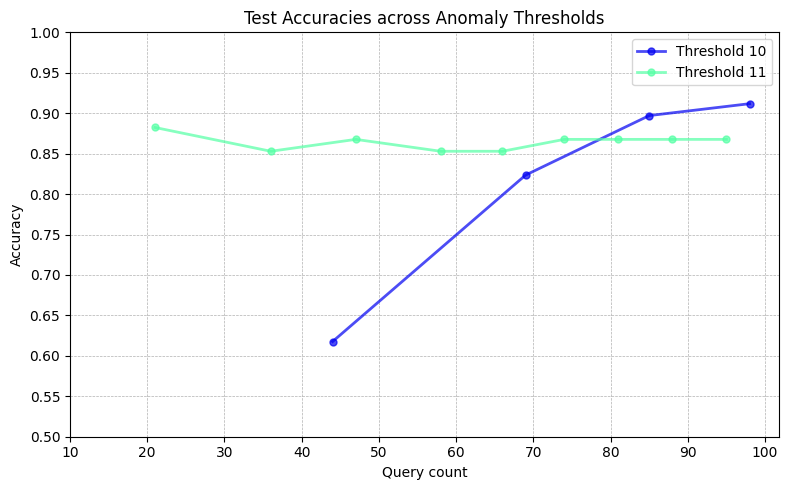

In [159]:
plot_accuracy_diff_thresholds([10, 11], acc_test_matrix, samples_matrix)

1.1873345231407453
Above the threshold lies 0.08088235294117647 of the data and below it 0.9191176470588235 of the data
[ 22  25  31 107 108 109 110 111 112 113 135 136 137 138 143 192 195 200
 205 208 234 235 252 254 275 277 278 279 280 281 282 284 286 343 388 471
 473 475 476 477 478 483 501 517]
500 are below threshold, 20 are above threshold with damaged, and 24 are above threshold undamaged


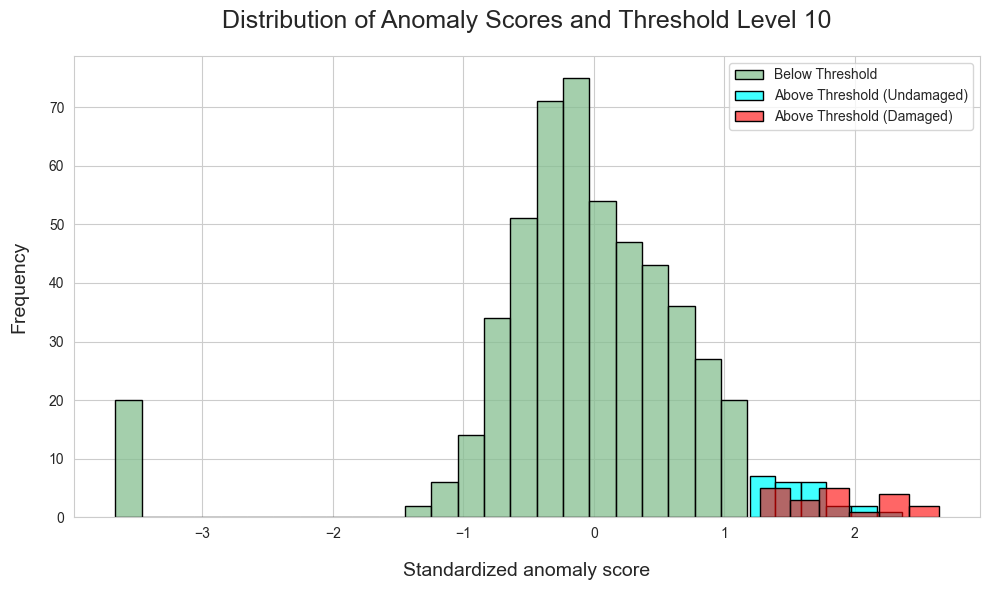

In [165]:
# okay, so it seems threshold 6 performs best let's visualize it
_, normalized_res = gaussian_scorer_multi(X_train_top_feats, window_size = 45,  grace_period = 20, method=3, plot=False) # min aggregation
threshold_6 = np.linspace(min(normalized_res), max(normalized_res), 14)[10] 
print(threshold_6)
print(f"Above the threshold lies {np.sum(normalized_res > threshold_6)/len(normalized_res)} of the data and below it {1- np.sum(normalized_res > threshold_6)/len(normalized_res)}"  
      f" of the data")
plot_distribution(normalized_res, "Distribution of Anomaly Scores and Threshold Level 10", threshold=threshold_6, damage_zone=lambda x: x >= 256)

### Method 3: ARIMA

In [40]:
import pandas as pd
import numpy as np
import arimafd as oa
import sys
from io import StringIO
sys.path.append('.\\..\\..\\..\\Chapter2-Z24-dataset')
from preprocess import get_avt_files, get_dataframes, preprocess_without_std

In [37]:
# get the acceleration signals
avt_files = get_avt_files("C:\\Users\\amroa\\Documents\\thesis\\data")
dfs_acc = get_dataframes(avt_files)
dfs_acc = pd.concat(dfs_acc, axis=0)
dfs_acc.reset_index(drop=True, inplace=True)
dfs_acc = dfs_acc.apply(lambda x: preprocess_without_std(x), axis=0) 
dfs_acc.shape

(10027008, 5)

In [ ]:
batch_size = 16384 # try with half of this also
nbr_samples = dfs_acc.shape[0]
change_points = []
windows = int(nbr_samples/batch_size) #  nbr of windows
anomalies= []

for i in range(windows):
    print(f"--- iter {i} ---")
    arima = oa.Arima_anomaly_detection(ar_order=4)
    window_1 = dfs_acc[i*batch_size:(i+1)*batch_size]
    window_2 = dfs_acc[(i+1)*batch_size:(i+2)*batch_size]
    arima.fit(window_1, window = int(batch_size//2), window_insensitivity = batch_size - 1)
    ts_anomaly = arima.predict(window_2, window = int(batch_size//2), window_insensitivity= batch_size - 1)
    np.save(f"arima_{i}.npy", ts_anomaly.to_numpy())

In [41]:
# extract the relevant file indices for training and testing separately
test_indices=  np.array([])
train_indices=  np.array([])

for i in range(17):
    random.seed(i)
    nbr_splits = 36 #  recall 612/17 = 36, where 612 = total nbr of epochs, 17 is nbr of scenarios
    test_split = 4
    test_indices = np.append(test_indices, i*nbr_splits + np.array(random.sample(range(nbr_splits), test_split)))
    train_indices = np.append(train_indices,  i*nbr_splits+ np.array([x for x in range(nbr_splits) if x not in test_indices]))

print(len(train_indices))

544


In [44]:
def plot_anomalies(title, path):
    # first window always healthy
    perc_ones = [0] # percent of ones in each window
    nbr_epochs = 544
    tot_epochs = 611
    for i in range(tot_epochs):
        if i in train_indices:
            cur_window = np.load(f"{path}/arima_{i}.npy")
            position_ones = np.where(cur_window == 1)[0]
            perc_ones.append(len(position_ones)/batch_size)

    scaler = StandardScaler()
    counts = scaler.fit_transform(np.array(perc_ones).reshape(-1, 1)).flatten()

    plt.figure(figsize=(15, 6)) 
    print(len(counts), np.where(counts > 3.5)[0])
    plt.bar(range(len(counts)), counts)
    plt.xlabel('Epoch (2.7 min ~ 16,384 samples)')
    plt.ylabel('(Standardized) percent of anomalies per epoch')
    plt.ylim(0, 1.10*max(counts))
    plt.title(title)

    for i in range(0, nbr_epochs+1, int(nbr_epochs/17)):
        plt.axvline(x=i, color='red', linestyle='--', linewidth=0.8)

    text_pos = [i+int(nbr_epochs/(2*17)) for i in range(0, nbr_epochs, int(nbr_epochs/17))]
    for idx, pos in enumerate(text_pos):
        plt.text(pos, max(counts)*0.9, f'DS {idx+1}', ha='center', color='red')

    plt.show()

    return counts

544 [ 30  65 149 188 238 244 250 488]


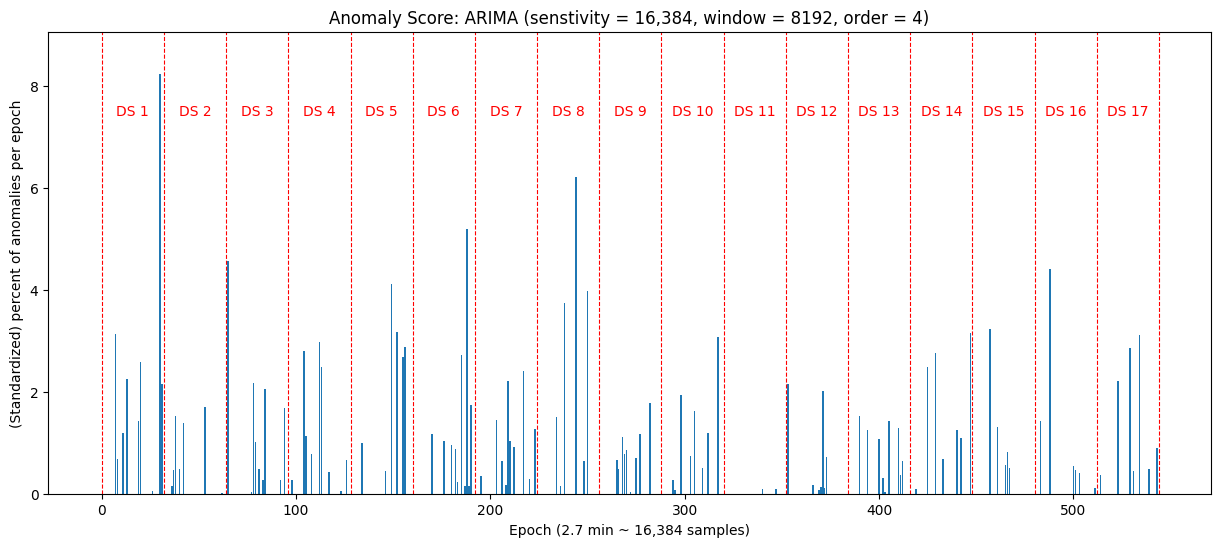

In [45]:
n_res = plot_anomalies("Anomaly Score: ARIMA (senstivity = 16,384, window = 8192, order = 4)", "./arima_16383_sens_8192_win")

544 [ 54 172 202 206 272 422]


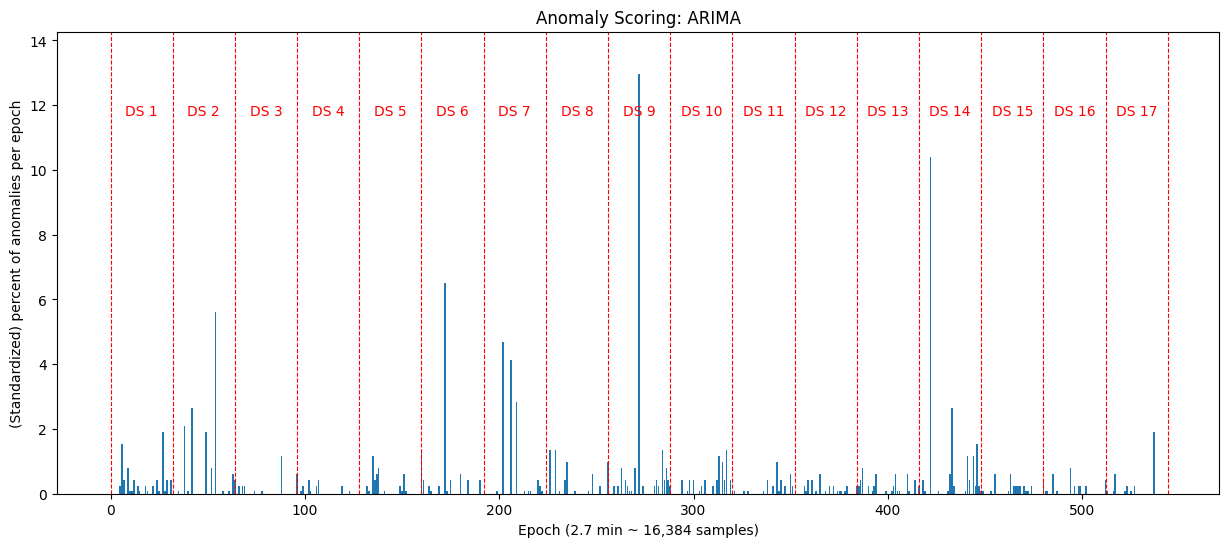

In [253]:
#n_res = plot_anomalies("Anomaly Scoring: ARIMA", "./arima_ar9_win8192_sens16383") 
n_res = plot_anomalies("Anomaly Scoring: ARIMA", "./arima_100_sens_100_win") 

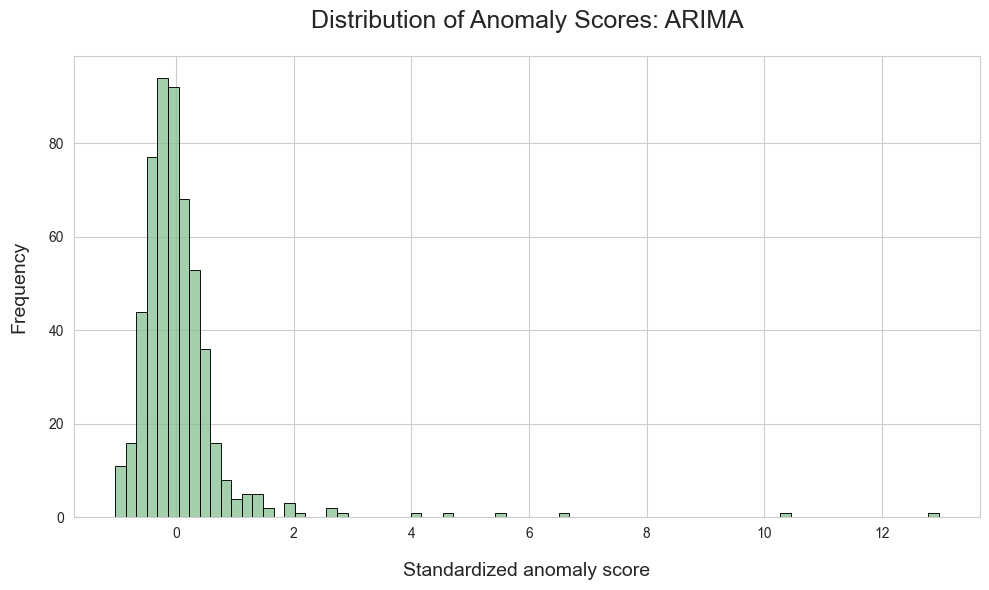

In [254]:
plot_distribution(n_res, "Distribution of Anomaly Scores: ARIMA")

In [280]:
# AL
test_accuracies, train_accuracies, samples_used = ad_to_al(n_res, warm_st=False)

12.971276124021484
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only one unique number
The training data contains only

0.9558823529411765


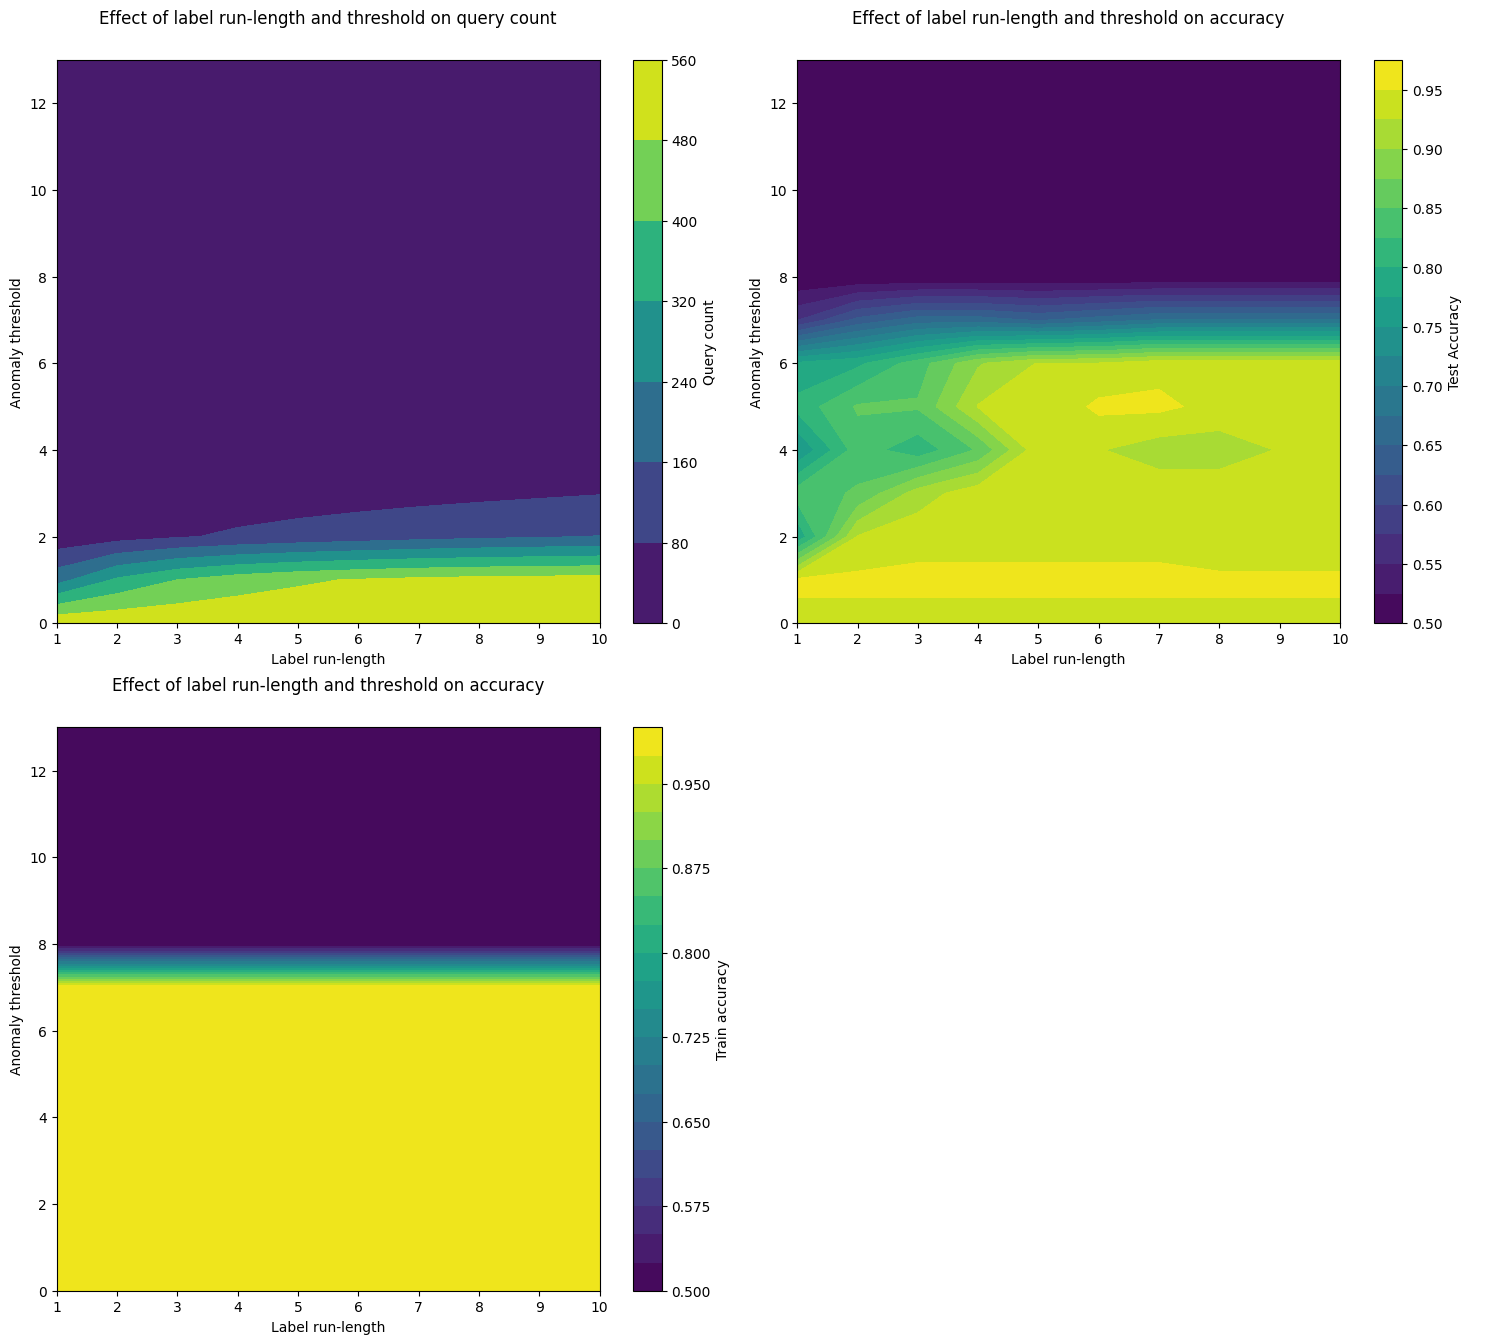

In [281]:
acc_train_matrix, acc_test_matrix, samples_matrix = plot_contour_al(train_accuracies, test_accuracies, samples_used)

[ 5 10 15 20 25 30 35 40 45 50]
[0.80882353 0.85294118 0.85294118 0.92647059 0.92647059 0.95588235
 0.95588235 0.94117647 0.94117647 0.94117647]
***
[ 4  8 12 16 20 24 28 32 36 40]
[0.77941176 0.79411765 0.83823529 0.89705882 0.92647059 0.92647059
 0.94117647 0.94117647 0.94117647 0.94117647]
***


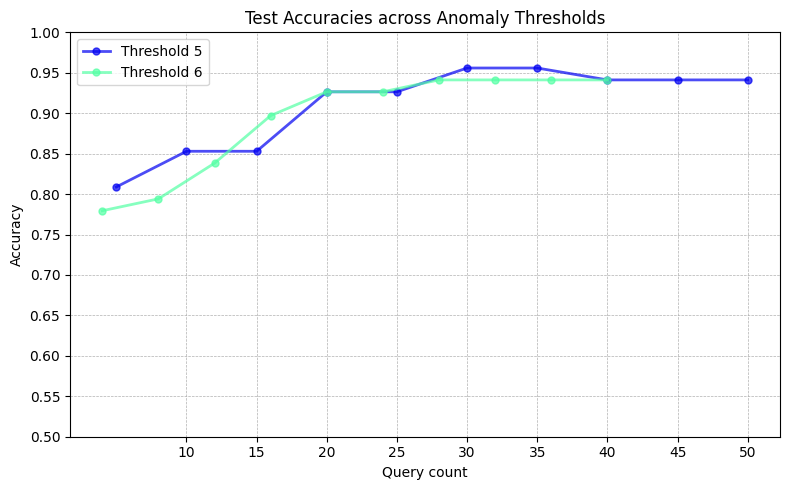

In [282]:
plot_accuracy_diff_thresholds([5, 6], acc_test_matrix, samples_matrix)

5.428673416592768
Above the threshold lies 0.007352941176470588 of the data and below it 0.9926470588235294 of the data
[ 54 172 272 422]
540 are below threshold, 2 are above threshold with damaged, and 2 are above threshold undamaged


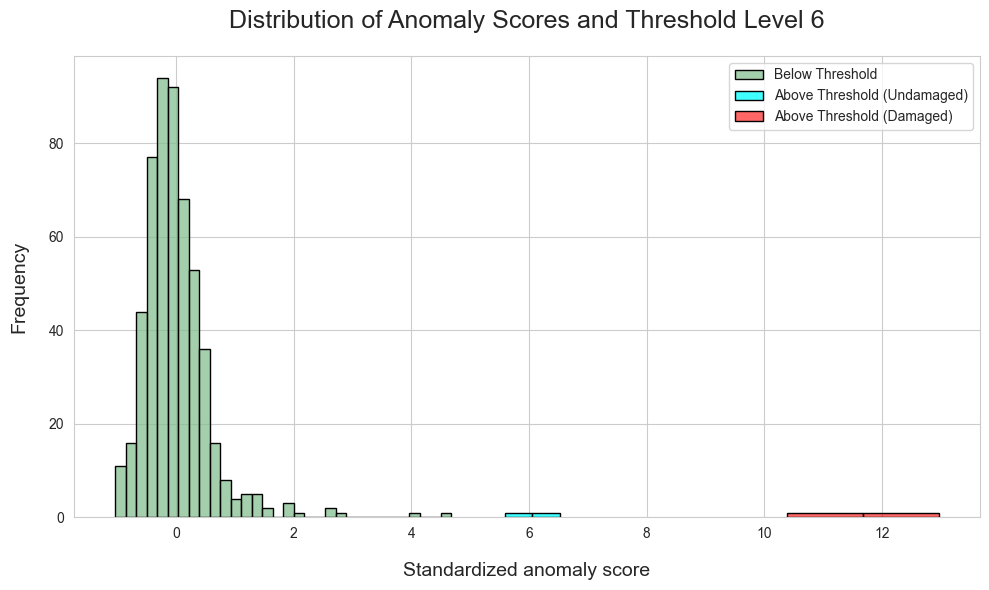

In [286]:
threshold_5 = np.linspace(min(n_res), max(n_res), 14)[6] 
print(threshold_5)
print(f"Above the threshold lies {np.sum(n_res > threshold_5)/len(n_res)} of the data and below it {1- np.sum(n_res > threshold_5)/len(n_res)}"  
      f" of the data")
plot_distribution(n_res, "Distribution of Anomaly Scores and Threshold Level 6", threshold=threshold_5, damage_zone=lambda x: x >= 256)

### Method 4: Concept drift 

In [130]:
from river import drift
from river import metrics
from river import tree

In [250]:
X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_feats
        ]
y_train = binarize(labels_train)
y_river_train = y_train.tolist()  
min_dif = 1000
for w in [10, 15, 20, 25, 30, 35, 40, 45]:
    for s in [5, 10, 15, 20, 25, 30, 35, 40]:
        if s >= w - 20:
            continue
        # Combine X_river and y_river_train into a single dataset
        dataset = zip(X_river, y_river_train)
        adwin = drift.KSWIN(alpha=0.009, window_size = w, stat_size=s, seed=42)
        changes = []
        i = 0
        for x, y in dataset:
            val = sum(abs(value) for value in x.values())
            _ = adwin.update(val)
            i += 1
            if adwin.drift_detected:
                changes.append(i)
                print(f"Change detected at index {i}, input value: {val}")
        
        chg_np = np.array(changes)
        chg_np = chg_np[chg_np > 255]
        if len(chg_np) > 0:
            diff = chg_np[0] - 256
            if diff < min_dif:
                print(f"min df at {w} and {s} is {diff}")
                min_dif = diff


Change detected at index 116, input value: 72.23265990116718
Change detected at index 172, input value: 66.40940858425311
Change detected at index 261, input value: 50.465364126402356
Change detected at index 301, input value: 42.08723060362949
Change detected at index 357, input value: 45.720460871290605
Change detected at index 401, input value: 50.845635523702754
Change detected at index 466, input value: 62.39831160620128
Change detected at index 506, input value: 63.96193424103376
min df at 30 and 5 is 5
Change detected at index 61, input value: 54.1134578805316
Change detected at index 113, input value: 75.3066925969611
Change detected at index 197, input value: 47.74821812102632
Change detected at index 280, input value: 82.40460927083706
Change detected at index 323, input value: 54.37973023458515
Change detected at index 358, input value: 46.19147156703572
Change detected at index 412, input value: 64.20697443886225
Change detected at index 466, input value: 62.39831160620128


In [268]:
# Combine X_river and y_river_train into a single dataset
dataset = zip(X_river, y_river_train)
adwin = drift.KSWIN(alpha=0.01, window_size = 30, stat_size=5, seed=42)
changes = []
i = 0
for x, y in dataset:
    val = sum(abs(value) for value in x.values())
    _ = adwin.update(val)
    i += 1
    if adwin.drift_detected:
        changes.append(i)
        print(f"Change detected at index {i}, input value: {val}")


Change detected at index 116, input value: 72.23265990116718
Change detected at index 172, input value: 66.40940858425311
Change detected at index 261, input value: 50.465364126402356
Change detected at index 301, input value: 42.08723060362949
Change detected at index 357, input value: 45.720460871290605
Change detected at index 401, input value: 50.845635523702754
Change detected at index 466, input value: 62.39831160620128
Change detected at index 506, input value: 63.96193424103376


Change detected at index 68, input value: 50.63908196865761
Change detected at index 118, input value: 63.618583406232986
Change detected at index 172, input value: 66.40940858425311
Change detected at index 222, input value: 50.92647454181557
Change detected at index 284, input value: 81.41833029049897
Change detected at index 361, input value: 49.69949143964021
Change detected at index 468, input value: 55.156441980875606
Change detected at index 522, input value: 44.317889825505745


In [170]:
X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_feats
        ]
y_train = binarize(labels_train)
y_river_train = y_train.tolist()  

# Combine X_river and y_river_train into a single dataset
dataset = zip(X_river, y_river_train)
i = -1
ph = drift.PageHinkley(min_instances=50)
for x, y in dataset:
    mean_x = sum(abs(value)*abs(value) for value in x.values())
    #mean_x = sum(x.values())
    i = i + 1
    _ = ph.update(mean_x)
    if ph.drift_detected:
        print(f"Change detected at index {i}, input value: {mean_x}")

Change detected at index 49, input value: 84.61459307923143
Change detected at index 99, input value: 39.653615335784025
Change detected at index 149, input value: 57.36089482813027
Change detected at index 199, input value: 155.07580214175766
Change detected at index 249, input value: 29.668402553231264
Change detected at index 299, input value: 36.37915235648901
Change detected at index 349, input value: 148.7775413166851
Change detected at index 399, input value: 47.22800817550402
Change detected at index 449, input value: 63.973142071300956
Change detected at index 499, input value: 82.73078140542225


In [128]:
X_river = [
            {f"feature_{i}": value for i, value in enumerate(sample)}
            for sample in X_train_top_feats
        ]
y_train = binarize(labels_train)
y_river_train = y_train.tolist()  

# Combine X_river and y_river_train into a single dataset
dataset = zip(X_river, y_river_train)
i = -1
ph = drift.PageHinkley()
drifts = 0
for x, y in dataset:
    #mean_x = sum(abs(value) for value in x.values())
    mean_x = sum(x.values())
    i = i + 1
    _ = ph.update(mean_x)
    if ph.drift_detected:
        drifts+=1
        print(f"Change detected at index {i}, input value: {mean_x}")

Change detected at index 29, input value: -18.46407083964303
Change detected at index 59, input value: -11.804376312270366
Change detected at index 89, input value: 5.328830571662262
Change detected at index 119, input value: -25.94326271511791
Change detected at index 149, input value: -29.663347797391737
Change detected at index 179, input value: -33.33678865446554
Change detected at index 209, input value: -3.8699999787781683
Change detected at index 239, input value: -20.224052766570832
Change detected at index 269, input value: 11.265983384956582
Change detected at index 299, input value: 18.569451733040964
Change detected at index 334, input value: 52.935287361849
Change detected at index 364, input value: 33.21529361764239
Change detected at index 394, input value: 10.993514283209848
Change detected at index 424, input value: 21.699549215057388
Change detected at index 454, input value: 28.795717003214477
Change detected at index 484, input value: 23.525887825062437
Change detec

#### Supplementary: Example usage of RiverML on iris from Sklearn

In [129]:
print(drifts)

17


In [79]:
"""
from sklearn import datasets as skdatasets  # Import to avoid naming conflicts
from river import active
from river import datasets
from river import linear_model
from river import metrics

# Load the iris dataset from sklearn
iris_sk = skdatasets.load_iris()

# Prepare the data in a format compatible with river
X_river = [
    {f"feature_{i}": value for i, value in enumerate(sample)}
    for sample in iris_sk['data']
]
y_river = iris_sk['target'].tolist()  # Converting to list for easier iteration

metric = metrics.Accuracy()
base_model = linear_model.LogisticRegression()
model = active.EntropySampler(base_model, seed=42)

n_samples_used = 0

# Process each sample in the dataset
for i in range(len(X_river)):
    x = X_river[i]
    y_true = y_river[i]
    y_pred, ask = model.predict_one(x)  # x is now a dictionary
    metric = metric.update(y_true, y_pred)

    if ask:
        n_samples_used += 1
        model = model.learn_one(x, y_true)  # Learn from the true label

print(metric)
print(f"Number of samples used for learning: {n_samples_used}")
"""

'\nfrom sklearn import datasets as skdatasets  # Import to avoid naming conflicts\nfrom river import active\nfrom river import datasets\nfrom river import linear_model\nfrom river import metrics\n\n# Load the iris dataset from sklearn\niris_sk = skdatasets.load_iris()\n\n# Prepare the data in a format compatible with river\nX_river = [\n    {f"feature_{i}": value for i, value in enumerate(sample)}\n    for sample in iris_sk[\'data\']\n]\ny_river = iris_sk[\'target\'].tolist()  # Converting to list for easier iteration\n\nmetric = metrics.Accuracy()\nbase_model = linear_model.LogisticRegression()\nmodel = active.EntropySampler(base_model, seed=42)\n\nn_samples_used = 0\n\n# Process each sample in the dataset\nfor i in range(len(X_river)):\n    x = X_river[i]\n    y_true = y_river[i]\n    y_pred, ask = model.predict_one(x)  # x is now a dictionary\n    metric = metric.update(y_true, y_pred)\n\n    if ask:\n        n_samples_used += 1\n        model = model.learn_one(x, y_true)  # Learn f